# Import PeekingDuck as a Module Demo

The modular design of PeekingDuck allows users to pick and choose the nodes they want to use. 

Users are also able to use PeekingDuck nodes with external libraries when designing their pipeline.

In this notebook, we demonstrate how to users can construct a custom PeekingDuck pipeline using:
- Data loaders such as [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) (available in `tensorflow>=2.3.0`),
- External models (not implemented as PeekingDuck nodes) such [`easyocr`](https://pypi.org/project/easyocr/), and
- Visualization packages such as [`matplotlib`](https://pypi.org/project/matplotlib/)


## Import the necessary modules

You can also do
```
from peekingduck.pipeline.nodes.input import live as pkd_live

live_node = pkd_live.Node()
```
to avoid potential name conflicts.


In [1]:
import os
from pathlib import Path

import cv2
import easyocr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from peekingduck.pipeline.nodes.draw import bbox
from peekingduck.pipeline.nodes.model import yolo_license_plate

%matplotlib inline

In [2]:
# Workaround to force CPU only on machines with low GPU memory, ignore this
# when running on Colab
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Initialize PeekingDuck nodes

To change the node configuration, you can pass the new values to the `Node()` constructor as keyword arguments.

Refer to the [API Documentation](https://peekingduck.readthedocs.io/en/stable/master.html#api-documentation) for the configurable settings for each node.

In [5]:
yolo_lp_node = yolo_license_plate.Node()

bbox_config = {"show_labels": True}
bbox_node = bbox.Node(**bbox_config)


2022-03-11 15:08:22 peekingduck.pipeline.nodes.model.yolov4_license_plate.licenseplate_files.detector  INFO:  Yolo model loaded with following configs: 
	Model type: v4, 
	Input resolution: 416, 
	NMS threshold: 0.3, 
	Score threshold: 0.1 
2022-03-11 15:08:22 peekingduck.pipeline.nodes.draw.bbox  INFO:  Config for node draw.bbox is updated to: 'show_labels': True 


## Create a Dataset Loader with `tf.keras.utils.image_dataset_from_directory()`

Here, we are creating the data loader using external libraries, you can also create your own data loader class.

We are using [Open Images Dataset V6](https://storage.googleapis.com/openimages/web/index.html) as the dataset for this demo. We recommend using the third party [oidv6 PyPI package](https://pypi.org/project/oidv6/) to download the images necessary for this demo. Run the following command after installing:

```
oidv6 downloader en --dataset <path/to/data/oidv6> --type_data train --classes car --limit 10 --yes
```

*Note: The images downloaded may differ from the ones shown in this demo.*

In [6]:
data_dir = Path.cwd().resolve() / "data" / "oidv6" / "train"
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, batch_size=1, shuffle=False)

Found 10 files belonging to 1 classes.


## Create a Class to Parse License Plate Numbers Using OCR

In [7]:
class LPReader:
    def __init__(self, use_gpu):
        self.reader = easyocr.Reader(["en"], gpu=use_gpu)

    def read(self, image):
        """Reads text from the image and joins multiple multiple strings to a
        single string.
        """
        return " ".join(self.reader.readtext(image, detail=0))

In [8]:
reader = LPReader(False)

2022-03-11 15:08:22 easyocr.easyocr  WARNING:  Using CPU. Note: This module is much faster with a GPU. 


## The Inference Loop

By carefully constructing the input for each of the nodes, we can perform the inference loop without having to use PeekingDuck's [`Runner`](https://github.com/aimakerspace/PeekingDuck/blob/dev/peekingduck/runner.py#L31).

This grants us the flexibility of inspecting the data for debugging or interacting with the data to integrate the inference loop external processes.

We have also defined a utility function for retrieving the image region of the license plate with a highest confidence score to improve code clarity.
For more information on how to convert between bounding box and image coordinates, please refer to the ["Bounding Box vs Image Coordinates"](https://peekingduck.readthedocs.io/en/docs-v1.2/tutorials/01_hello_cv.html#bounding-box-vs-image-coordinates) section in our tutorials.

In [9]:
def get_best_license_plate(frame, bboxes, bbox_scores, width, height):
    """Returns the image region enclosed by the bounding box with the highest
    confidence score.
    """
    best_idx = np.argmax(bbox_scores)
    best_bbox = bboxes[best_idx].astype(np.float32).reshape((-1, 2))
    best_bbox[:, 0] *= width
    best_bbox[:, 1] *= height
    best_bbox = np.round(best_bbox).astype(int)

    return frame[slice(*best_bbox[:, 1]), slice(*best_bbox[:, 0])]


2022-03-11 15:08:26.626112: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


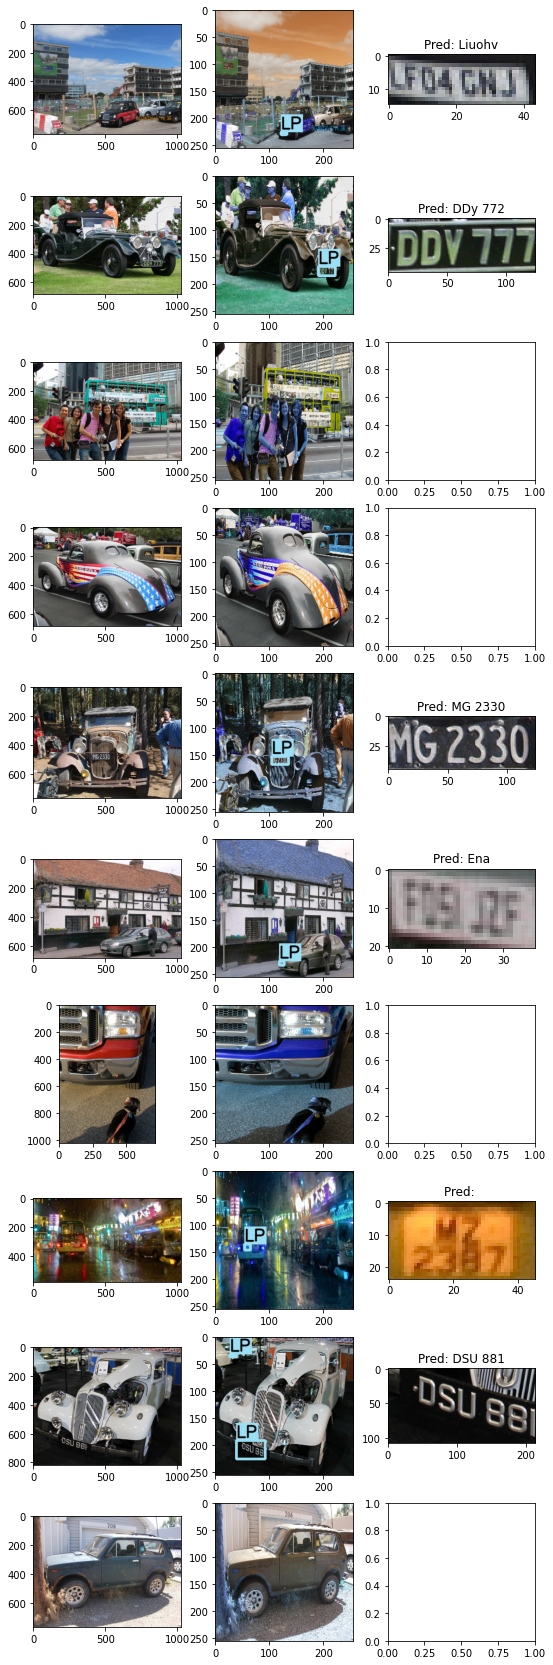

In [10]:
num_col = 3
# For visualization, we plot 3 columns, 1) the original image, 2) image with
# bounding box, and 3) the detected license plate region with license plate
# number prediction shown as the plot title 
fig, ax = plt.subplots(len(dataset), num_col, figsize=(num_col * 3, len(dataset) * 3))
for i, (element, path) in enumerate(zip(dataset, dataset.file_paths)):
    # TODO: Ensure model takes in BGR image after it's fixed
    image_orig = cv2.imread(path)
    image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
    height, width = image_orig.shape[:2]

    image = cv2.cvtColor(element[0].numpy().astype("uint8")[0], cv2.COLOR_RGB2BGR)

    yolo_lp_input = {"img": image}
    yolo_lp_output = yolo_lp_node.run(yolo_lp_input)

    bbox_input = {
        "img": image,
        "bboxes": yolo_lp_output["bboxes"],
        "bbox_labels": yolo_lp_output["bbox_labels"],
    }
    _ = bbox_node.run(bbox_input)

    ax[i][0].imshow(image_orig)
    ax[i][1].imshow(image[..., ::-1])
    # If there are any license plates detected, try to predict the license
    # plate number
    if len(yolo_lp_output["bboxes"]) > 0:
        lp_image = get_best_license_plate(
            image_orig, yolo_lp_output["bboxes"],
            yolo_lp_output["bbox_scores"],
            width,
            height,
        )
        lp_pred = reader.read(lp_image)
        ax[i][2].imshow(lp_image)
        ax[i][2].title.set_text(f"Pred: {lp_pred}")


The license plate prediction can be improved in some cases with image preprocessing but is beyond the scope of this tutorial.